# Taxi Fare Prediction Based On Machine Learning

In [ ]:
awk -v l=5000000 '(NR==1){header=$0;next}
                ((NR-1)%l==1) { 
                  close(file)
                  file=FILENAME; c=sprintf("%0.5d",c+1) 
                  gsub(/csv$/,c".csv",file)
                  print header > file
                }
                {print $0 > file}' train.csv

In [ ]:
# Import packages and data
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import keras
from haversine import haversine as hs
import sys
import time
import matplotlib.pyplot as plt
from math import sqrt

test_data = pd.read_csv('test.csv')
df = pd.read_csv('train.00001.csv', sep=",")
df.describe()

## Data Cleaning

In [ ]:
# Removes negative fare
df = df[df.fare_amount>=0]

# Removes rows with missing data such as NaN...
df = df.dropna(how = 'any', axis = 'rows')

# Remove rows with zeros since our location information should have non-zero numbers.
df = df[(df != 0).all(1)]

df.to_csv('train.00001.csv')

## EDA

6


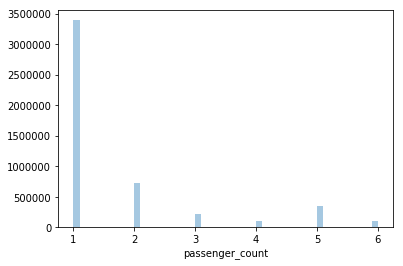

In [30]:
# Passenger_count distribution
df = df[df['passenger_count']<7]
sns.distplot(df['passenger_count'], kde = False)

4498891


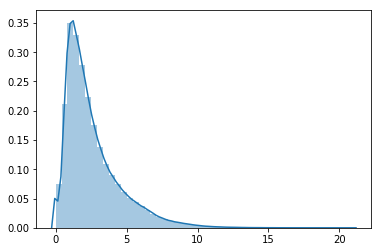

In [46]:
# Distance distribution
distance = []
for i in df.T:
    pickup = (round(df['pickup_latitude'][i],6), round(df['pickup_longitude'][i],6))
    dropoff = (round(df['dropoff_latitude'][i],6), round(df['dropoff_longitude'][i],6))
    temp = hs(pickup, dropoff)
    distance.append(temp)
df['distance']=distance
print(len(distance))
sns.distplot(distance)

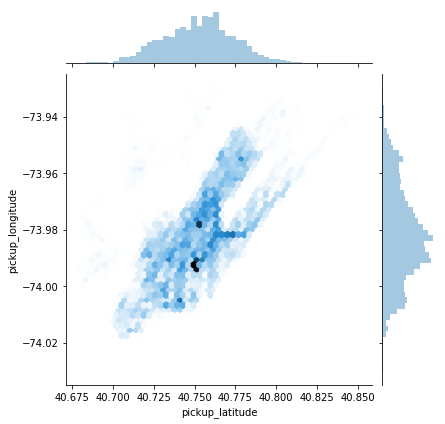

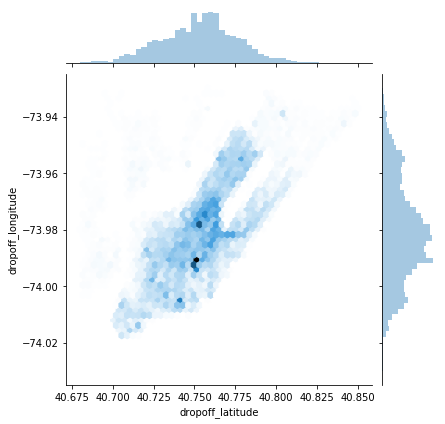

In [81]:
# Location distribution
df = df[(40.68 < df['pickup_latitude']) & (df['pickup_latitude'] < 40.85) & (-74.03 < df['pickup_longitude']) & (df['pickup_longitude'] < -73.93)]
df = df[(40.68 < df['dropoff_latitude']) & (df['dropoff_latitude'] < 40.85) & (-74.03 < df['dropoff_longitude']) & (df['dropoff_longitude'] < -73.93)]
sns.jointplot(df['pickup_latitude'], df['pickup_longitude'], kind="hex")
sns.jointplot(df['dropoff_latitude'], df['dropoff_longitude'], kind="hex")

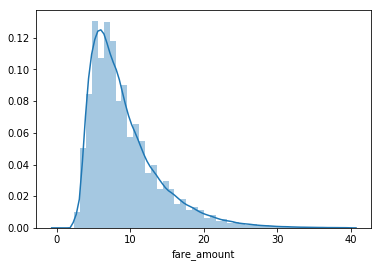

In [50]:
# Fare amount distribution
df = df[df['fare_amount']<40]
sns.distplot(df['fare_amount'])

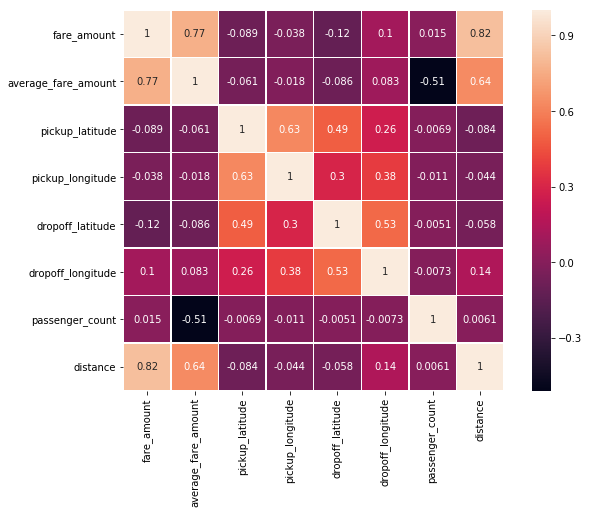

In [80]:
# Heatmap for correlation
f, ax = plt.subplots(figsize=(10, 7))
df['average_fare_amount'] = df['fare_amount'] / df['passenger_count']
internal_chars = ['fare_amount', 'average_fare_amount','pickup_datetime','pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude','passenger_count','distance']
corr = df[internal_chars].corr()
sns.heatmap(corr, square=True, linewidths=.5, annot=True)
plt.show()

## PDA

In [1]:
# Load some python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
# Load preprocessed train data
test = pd.read_csv("train.00001.csv")
print(">>  Data Loaded")

>>  Data Loaded


In [3]:
# Check the size of the data
print('New size: %d' % len(test))

New size: 4882711


In [4]:
# Check the range of longitude
min(test.pickup_longitude.min(), test.dropoff_longitude.min()), \
max(test.pickup_longitude.max(), test.dropoff_longitude.max())

(-3426.60895, 3457.62235)

In [5]:
# Check the range of latitude
min(test.pickup_latitude.min(), test.dropoff_latitude.min()), \
max(test.pickup_latitude.max(), test.dropoff_latitude.max())

(-3488.079513, 3345.9173530000007)

In [6]:
# This line removes lines that have longitude and latitude value over map range
test = test[test.pickup_longitude<100]
test = test[test.pickup_longitude>-100]
test = test[test.pickup_latitude<100]
test = test[test.pickup_latitude>-100]
print("longitude and latitude errors fixed")

longitude and latitude errors fixed


In [8]:
# Set the boundary of new york city map
def select_within_boundingbox(test, BB):
    return (test.pickup_longitude >= BB[0]) & (test.pickup_longitude <= BB[1]) & \
           (test.pickup_latitude >= BB[2]) & (test.pickup_latitude <= BB[3]) & \
           (test.dropoff_longitude >= BB[0]) & (test.dropoff_longitude <= BB[1]) & \
           (test.dropoff_latitude >= BB[2]) & (test.dropoff_latitude <= BB[3])
            
# Load image of NYC map
BB = (-74.8, -72.8, 40.4, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

In [9]:
# Select points with in the boundary of map
print('Old size: %d' % len(test))
test = test[select_within_boundingbox(test, BB)]
print('New size: %d' % len(test))

Old size: 4882584
New size: 4876704


In [10]:
# This function will plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(test.pickup_longitude, test.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pick-Up Locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(test.dropoff_longitude, test.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Drop-Off Locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

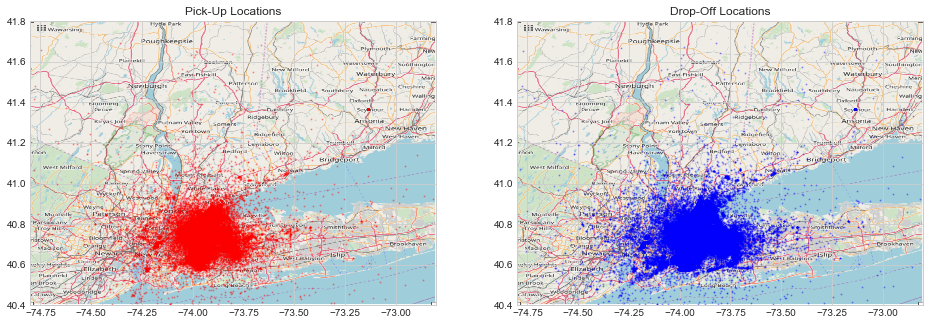

In [11]:
# Plot training data on map
plot_on_map(test, BB, nyc_map, s=1, alpha=0.3)

# Models

## GradientBoostingRegressor

In [ ]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.00001.csv')

y_train = train_data['fare_amount'][0:4870000]
y_test = train_data['fare_amount'][4870000:]

In [ ]:
train_data = df.iloc[:]
del train_data['Unnamed: 0']
del train_data['key']
del train_data['pickup_datetime']
del train_data['fare_amount']
train_data1 = train_data[0:4870000]
test_data = train_data[4870000:]

In [ ]:
clf = ensemble.AdaBoostRegressor()
clf.fit(train_data1, y_train)
mse = mean_squared_error(y_test, clf.predict(test_data))

print(mse)

## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from haversine import haversine as hs
from math import sqrt
import numpy as np
import pandas as pd

"""
data = pd.read_csv('train.csv')
df = pd.DataFrame(data)
train_data = df.iloc[0:40000]
test_data = df.iloc[40000:50000]
train_label = train_data.fare_amount
test_label = test_data.fare_amount
del train_data['fare_amount']
del test_data['fare_amount']
del train_data['Unnamed: 0']
del test_data['Unnamed: 0']
"""

# Read dataset
data = pd.read_csv('train_density.csv')
df = pd.DataFrame(data)

train_data = df.iloc[0:40000]
test_data = df.iloc[40000:50000]
train_label = train_data.fare_amount
test_label = test_data.fare_amount
del train_data['fare_amount']
del test_data['fare_amount']

regr = RandomForestRegressor(max_depth=None, random_state=0, n_estimators=100)
regr.fit(train_data, train_label)
print(regr.feature_importances_)
rmse = sqrt(mean_squared_error(test_label, regr.predict(test_data)))
print("Testing set RMSE: ${:1.2f}".format(rmse))

In [ ]:
import pandas as pd
import sys

class ShowProcess():
    i = 0 
    max_steps = 0
    max_arrow = 50 # length of bar
    infoDone = 'done'
    
    def __init__(self, max_steps, infoDone = 'Done'):
        self.max_steps = max_steps
        self.i = 0
        self.infoDone = infoDone

    def show_process(self, i=None):
        if i is not None:
            self.i = i
        else:
            self.i += 1
        num_arrow = int(self.i * self.max_arrow / self.max_steps)
        num_line = self.max_arrow - num_arrow
        percent = self.i * 100.0 / self.max_steps
        process_bar = '[' + '>' * num_arrow + '-' * num_line + ']'\
                      + '%.2f' % percent + '%' + '\r'
        sys.stdout.write(process_bar)
        sys.stdout.flush()
        if self.i >= self.max_steps:
            self.close()

    def close(self):
        print('')
        print(self.infoDone)
        self.i = 0

process_bar = ShowProcess(len(df), '')
data = pd.read_csv('train.csv')
df = pd.DataFrame(data)
season = list(df['month'])
for i in range(len(season)):
    process_bar.show_process()
    if int(season[i]) in [4,5,6]:
        season[i] = 0
    elif int(season[i]) in [7,8,9]:
        season[i] = 1
    elif int(season[i]) in [10,11,12]:
        season[i] = 2
    elif int(season[i]) in [1,2,3]:
        season[i] = 3
df['season'] = season
del df['month']

In [ ]:
process_bar = ShowProcess(len(df), '')
daynight = list(df['hour'])
for i in range(len(daynight)):
    process_bar.show_process()
    if int(daynight[i])>=7 and int(daynight[i])<=19:
        daynight[i]=0
    else:
        daynight[i]=1 
df['daynight'] = daynight
del df['hour']

## DeepPrediction

In [ ]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from haversine import haversine as hs
import sys
import time
import matplotlib.pyplot as plt
from math import sqrt

print(tf.__version__)


class ShowProcess():
    i = 0
    max_steps = 0
    max_arrow = 50  # length of bar
    infoDone = 'done'

    def __init__(self, max_steps, infoDone='Done'):
        self.max_steps = max_steps
        self.i = 0
        self.infoDone = infoDone

    def show_process(self, i=None):
        if i is not None:
            self.i = i
        else:
            self.i += 1
        num_arrow = int(self.i * self.max_arrow / self.max_steps)
        num_line = self.max_arrow - num_arrow
        percent = self.i * 100.0 / self.max_steps
        process_bar = '[' + '>' * num_arrow + '-' * num_line + ']' \
                      + '%.2f' % percent + '%' + '\r'
        sys.stdout.write(process_bar)
        sys.stdout.flush()
        if self.i >= self.max_steps:
            self.close()

    def close(self):
        print('')
        print(self.infoDone)
        self.i = 0

data = pd.read_csv('train.csv')
df = pd.DataFrame(data)
train_data = df.iloc[0:400000]
test_data = df.iloc[400000:500000]
train_label = train_data.fare_amount
test_label = test_data.fare_amount
del train_data['fare_amount']
del test_data['fare_amount']
del train_data['Unnamed: 0']
del test_data['Unnamed: 0']

class PredictNet:
    def inception(inputs):
        x0 = keras.layers.Dense(32, activation=tf.nn.relu)(inputs)
        x1 = keras.layers.Dense(32, activation=tf.nn.relu)(inputs)
        x1 = keras.layers.Dense(32, activation=tf.nn.relu)(x1)
        x2 = keras.layers.Dense(32, activation=tf.nn.relu)(inputs)
        x2 = keras.layers.Dense(32, activation=tf.nn.relu)(x2)
        x2 = keras.layers.Dense(32, activation=tf.nn.relu)(x2)
        x3 = keras.layers.Dense(32, activation=tf.nn.relu)(inputs)
        x3 = keras.layers.Dense(32, activation=tf.nn.relu)(x3)
        x3 = keras.layers.Dense(32, activation=tf.nn.relu)(x3)
        x3 = keras.layers.Dense(32, activation=tf.nn.relu)(x3)
        x = keras.layers.concatenate([x0, x1, x2, x3], axis=0)
        return x

    def prediction(inputs):
        # x = keras.layers.Dense(256, activation=tf.nn.relu)(inputs)
        x = PredictNet.inception(inputs)
        # x = keras.layers.Dropout(0.2)(x)
        x = PredictNet.inception(x)
        # x = keras.layers.Dropout(0.2)(x)
        x = PredictNet.inception(x)
        # x = keras.layers.Dropout(0.2)(x)
        # x = keras.layers.Dense(64, activation=tf.nn.relu)(x)
        # x = keras.layers.Dense(32, activation=tf.nn.relu)(x)
        # x = keras.layers.Dense(32, activation=tf.nn.relu)(x)
        x = keras.layers.Dense(1)(x)
        return x

    def build():
        inputs = keras.layers.Input(shape=(train_data.shape[1],))
        outputs = PredictNet.prediction(inputs)
        model = keras.Model(inputs=inputs, outputs=outputs)
        return model

model = PredictNet.build()
optimizer = tf.train.AdamOptimizer(0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
model.summary()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    process_bar.show_process()

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Root Mean Square Error [1$]')
  plt.plot(history.epoch, np.sqrt(np.array(history.history['mean_squared_error'])),
           label='Train Loss')
  plt.plot(history.epoch, np.sqrt(np.array(history.history['val_mean_squared_error'])),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 20])

EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
process_bar = ShowProcess(EPOCHS, '')

# Store training stats
history = model.fit(train_data, train_label, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])


[loss, mse] = model.evaluate(test_data, test_label, verbose=0)
rmse = sqrt(mse)
print("Testing set Root Mean Abs Error: ${:1.2f}".format(rmse))